# Programming Project #2: Image Quilting

## CS445: Computational Photography - Fall 2019

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import utils
import os
from random import randint
import math

In [2]:
from utils import cut # default cut function for seam finding section

### Part I: Randomly Sampled Texture (10 pts)

<IPython.core.display.Javascript object>


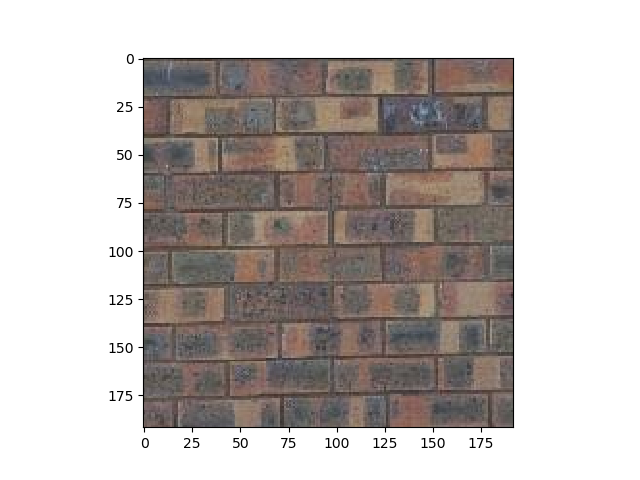

In [3]:
sample_img_dir = 'samples/bricks_small.jpg' # feel free to change
sample_img = None
if os.path.exists(sample_img_dir):
    sample_img = cv2.imread(sample_img_dir)
    sample_img = cv2.cvtColor(sample_img,cv2.COLOR_BGR2RGB)
    fig, axes = plt.subplots(1, 1)
    axes.imshow(sample_img)

<IPython.core.display.Javascript object>


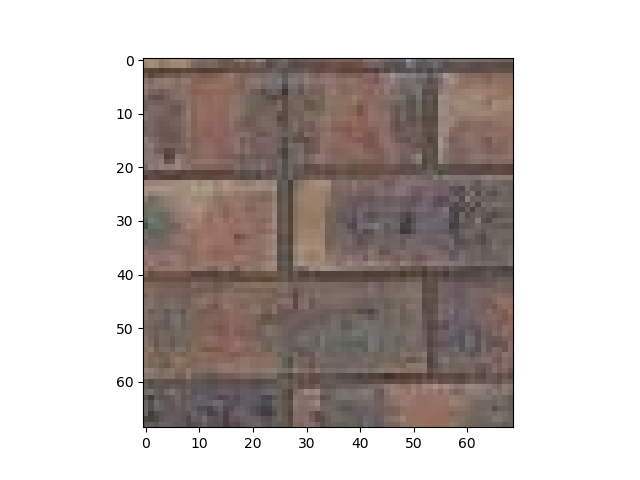

In [4]:
def sample_image(width,sample_img):
    row = sample_img.shape[0]
    column = sample_img.shape[1]
    random_row = randint(0,row - width)
    random_column = randint(0,column - width)
    new = sample_img[random_row:random_row + width,random_column:random_column + width,:]
    return new


fig, axes = plt.subplots(1, 1)
axes.imshow(sample_image(69,sample_img))


In [5]:
def quilt_random(sample, out_size, patch_size):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.

    :param sample: numpy.ndarray   The image you read from sample directory
    :param out_size: int            The width of the square output image
    :param patch_size: int          The width of the square sample patch
    :return: numpy.ndarray
    """
    size = out_size
    output = np.zeros(shape=(size,size,3))
    new = sample_image(patch_size,sample_img) 
    y = 0
    size_patch = new.shape[0]
    while y < size:
        x = 0
        while x < size:
            if x + size_patch > size and y + size_patch > size:
                new = sample_image(patch_size,sample_img)
                output[y:size,x:size] = new[0:size-y,0:size-x]
                break
            if x + size_patch > size:
                new = sample_image(patch_size,sample_img)
                output[y:size_patch+y,x:size] = new[:,0:size-x]
                break
            if y + size_patch > size:
                new = sample_image(patch_size,sample_img)
                output[y:size,x:size_patch+x] = new[0:size-y,:]
                x += size_patch
            else:
                new = sample_image(patch_size,sample_img)
                output[y:size_patch+y,x:size_patch+x] = new
                x += size_patch
        y += size_patch
    output = output.astype('uint8')
    return output

<IPython.core.display.Javascript object>


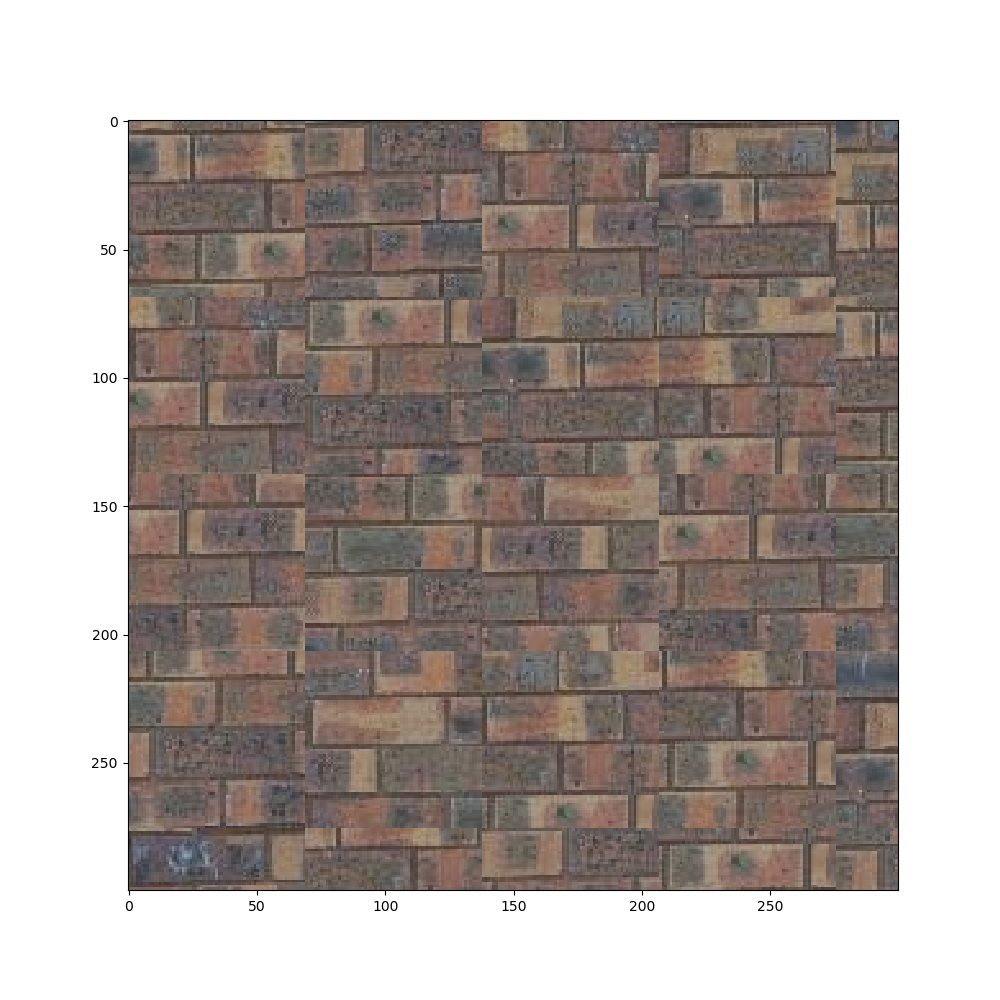

In [6]:
out_size = 300  # feel free to change to debug
patch_size = 69 # feel free to change to debug
res = quilt_random(sample_img, out_size, patch_size)
fig, axes = plt.subplots(1, 1)
fig.set_size_inches(10, 10)
axes.imshow(res)

### Part II: Overlapping Patches (30 pts)

In [9]:
def ssd_patch_left(overlap,left_patch,patch_size):
    M = np.zeros(shape=(patch_size,patch_size,3))
    M[:,:overlap,:] = 1
    T = np.zeros(shape=(patch_size,patch_size,3))
    T[:,:overlap,:] = left_patch[:, patch_size-overlap:patch_size,:] #template overlap real values
    T/255.0
    I = sample_img/255.0
    ssd = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    return ssd

In [10]:
def ssd_patch_up(overlap,up_patch,patch_size):
    M = np.zeros(shape=(patch_size,patch_size,3))
    M[:overlap,:,:] = 1
    T = np.zeros(shape=(patch_size,patch_size,3))
    test = up_patch[patch_size-overlap:patch_size, :,:]
    test_2 = T[:overlap,:,:]
    T[:overlap,:,:] = up_patch[patch_size-overlap:patch_size, :,:] #template overlap real values
    T/255.0
    I = sample_img/255.0
    ssd = ((M*T)**2).sum() - 2 * cv2.filter2D(I, ddepth=-1, kernel = M*T) + cv2.filter2D(I ** 2, ddepth=-1, kernel=M)
    return ssd

In [12]:
def choose_sample(k,ssd,overlap,patch_size,input_image):
    input_image_size = input_image.shape[0]
    #print(input_image_size)
    row = []
    col = []
    z = []
    while len(row) < k:
        row_1, col_1, z_1 = np.where(ssd == np.amin(ssd))
        if (patch_size-1)/2<row_1[0] < input_image_size-((patch_size-1)/2) and (patch_size-1)/2<col_1[0] < input_image_size-((patch_size-1)/2):
            row.append(row_1[0])
            col.append(col_1[0])
            z.append(z_1[0])
        ssd[row_1,col_1,z_1] = 10000000000000
    #print (row, col, z)
    rand_int = randint(0,k-1)
    return input_image[row[rand_int]-int(((patch_size-1)/2)):(row[rand_int]-int((patch_size-1)/2))+patch_size,col[rand_int]-int((patch_size-1)/2):(col[rand_int]-int((patch_size-1)/2))+patch_size,:]

In [19]:
def quilt_simple(sample, out_size, patch_size, overlap, k):
    """
    Randomly samples square patches of size patchsize from sample in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param k: int how many random samples to choose from smallest ssd values.
    :return: numpy.ndarray
    """
    output = np.zeros(shape=(out_size,out_size,3))
    y = 0
    t = 0
    while y < out_size:
        x = 0
        while x < out_size:
            if y == 0 and x == 0: #1
                random_sample = sample_image(patch_size,sample)
                output[:patch_size,:patch_size,:] = random_sample
                x += patch_size
            elif y ==0 and x + patch_size <= out_size: #2
                left_patch = output[y:patch_size,x-patch_size:x,:]
                ssd = ssd_patch_left(overlap,left_patch,patch_size)
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                output[y:patch_size,x:x+patch_size,:] = out
                x += patch_size
                #fig, axes = plt.subplots(1, 1)
                #fig.set_size_inches(10, 10)
                #axes.imshow(output)
                #plt.savefig(str(t)+".jpg")
                #t += 1
            elif y ==0 and x + patch_size > out_size:
                left_patch = output[y:patch_size,x-patch_size:x,:]
                ssd = ssd_patch_left(overlap,left_patch,patch_size)
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                output[y:patch_size,x:out_size,:] = out[:,:out_size-x,:]
                y += patch_size
                x = out_size + 1
                #fig, axes = plt.subplots(1, 1)
                #fig.set_size_inches(10, 10)
                #axes.imshow(output)
                #plt.savefig(str(t)+".jpg")
                #t += 1
            elif y + patch_size <= out_size and x == 0:
                up_patch = output[y-patch_size:y,x:x+patch_size,:]
                ssd = ssd_patch_up(overlap,up_patch,patch_size)
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                output[y:y+patch_size,x:x+patch_size,:] = out
                x += patch_size
                #fig, axes = plt.subplots(1, 1)
                #fig.set_size_inches(10, 10)
                #axes.imshow(output)
                #plt.savefig(str(t)+".jpg")
                #t += 1
            elif y + patch_size <= out_size and x + patch_size <= out_size:
                up_patch = output[y-patch_size:y,x:x+patch_size,:]
                left_patch = output[y:patch_size+y,x-patch_size:x,:]
                ssd_1 = ssd_patch_left(overlap,left_patch,patch_size)
                ssd_2  = ssd_patch_up(overlap,up_patch,patch_size)
                ssd = ssd_1 + ssd_2
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                output[y:y+patch_size,x:x+patch_size,:] = out
                x += patch_size
                #fig, axes = plt.subplots(1, 1)
                #fig.set_size_inches(10, 10)
                #axes.imshow(output)
                #plt.savefig(str(t)+".jpg")
                #t += 1
            elif y + patch_size <= out_size and x + patch_size > out_size:
                up_patch = np.zeros(shape=(patch_size,patch_size,3))
                up_patch[:,:out_size-x,:] = output[y-patch_size:y,x:out_size,:]
                left_patch = output[y:patch_size+y,x-patch_size:x,:]
                ssd_1 = ssd_patch_left(overlap,left_patch,patch_size)
                ssd_2  = ssd_patch_up(overlap,up_patch,patch_size)
                ssd = ssd_1 + ssd_2
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                output[y:y+patch_size,x:x+patch_size,:] = out[:,:out_size-x,:]
                x = out_size + 1
                y = y + patch_size
                #fig, axes = plt.subplots(1, 1)
                #fig.set_size_inches(10, 10)
                #axes.imshow(output)
                #plt.savefig(str(t)+".jpg")
                #t += 1
            elif y + patch_size > out_size and x == 0:
                up_patch = output[y-patch_size:y,x:x+patch_size,:]
                ssd = ssd_patch_up(overlap,up_patch,patch_size)
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                output[y:out_size,x:x+patch_size,:] = out[:out_size-y,:,:]
                x += patch_size
                #fig, axes = plt.subplots(1, 1)
                #fig.set_size_inches(10, 10)
                #axes.imshow(output)
                #plt.savefig(str(t)+".jpg")
                #t += 1
            elif y + patch_size > out_size and x + patch_size <= out_size:
                up_patch = output[y-patch_size:y,x:x+patch_size,:]
                left_patch = np.zeros(shape=(patch_size,patch_size,3))
                left_patch[:out_size-y,:,:] = output[y:out_size,x-patch_size:x,:]
                ssd_1 = ssd_patch_left(overlap,left_patch,patch_size)
                ssd_2  = ssd_patch_up(overlap,up_patch,patch_size)
                ssd = ssd_1 + ssd_2
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                output[y:y+patch_size,x:x+patch_size,:] = out[:out_size-y,:,:]
                x += patch_size
                #fig, axes = plt.subplots(1, 1)
                #fig.set_size_inches(10, 10)
                #axes.imshow(output)
                #plt.savefig(str(t)+".jpg")
                #t += 1
            elif y + patch_size > out_size and x + patch_size > out_size:
                up_patch = np.zeros(shape=(patch_size,patch_size,3))
                up_patch[:,:out_size-x,:] = output[y-patch_size:y,x:out_size,:]
                left_patch = np.zeros(shape=(patch_size,patch_size,3))
                left_patch[:out_size-y,:,:] = output[y:out_size,x-patch_size:x,:]
                ssd_1 = ssd_patch_left(overlap,left_patch,patch_size)
                ssd_2  = ssd_patch_up(overlap,up_patch,patch_size)
                ssd = ssd_1 + ssd_2
                out = choose_sample(k,ssd,overlap,patch_size,sample)
                output[y:y+patch_size,x:x+patch_size,:] = out[:out_size-y,:out_size-x,:]
                x += patch_size
                #fig, axes = plt.subplots(1, 1)
                #fig.set_size_inches(10, 10)
                #axes.imshow(output)
                #plt.savefig(str(t)+".jpg")
                #t += 1
                return output
                




<IPython.core.display.Javascript object>


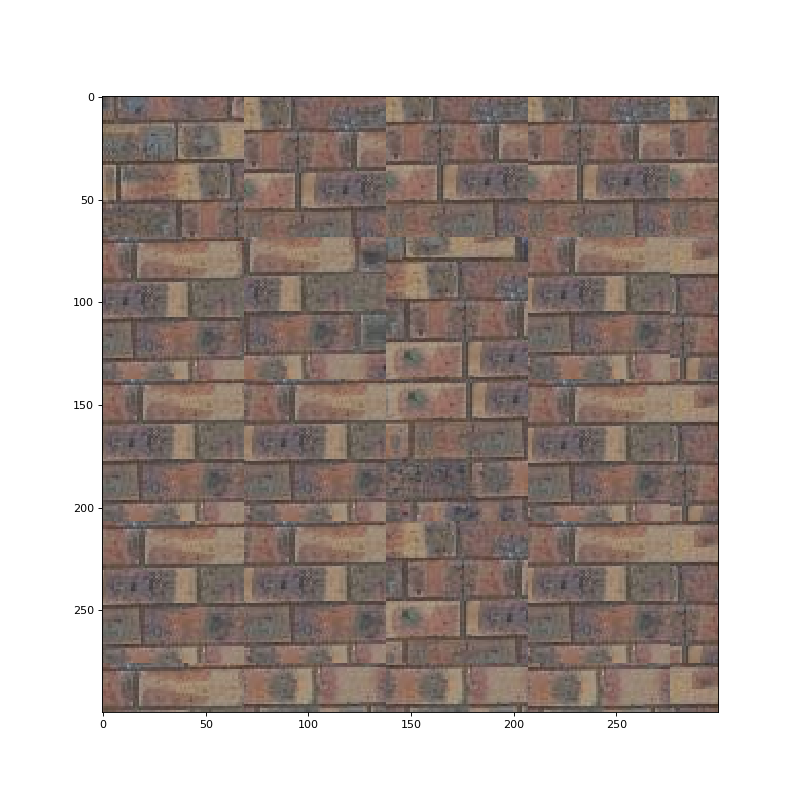

In [23]:
output = quilt_simple(sample_img, 300, 69, 20, 10)
output = output.astype('uint8')
fig, axes = plt.subplots(1, 1)
fig.set_size_inches(10, 10)
axes.imshow(output)


### Part III: Seam Finding (20 pts)


<IPython.core.display.Javascript object>


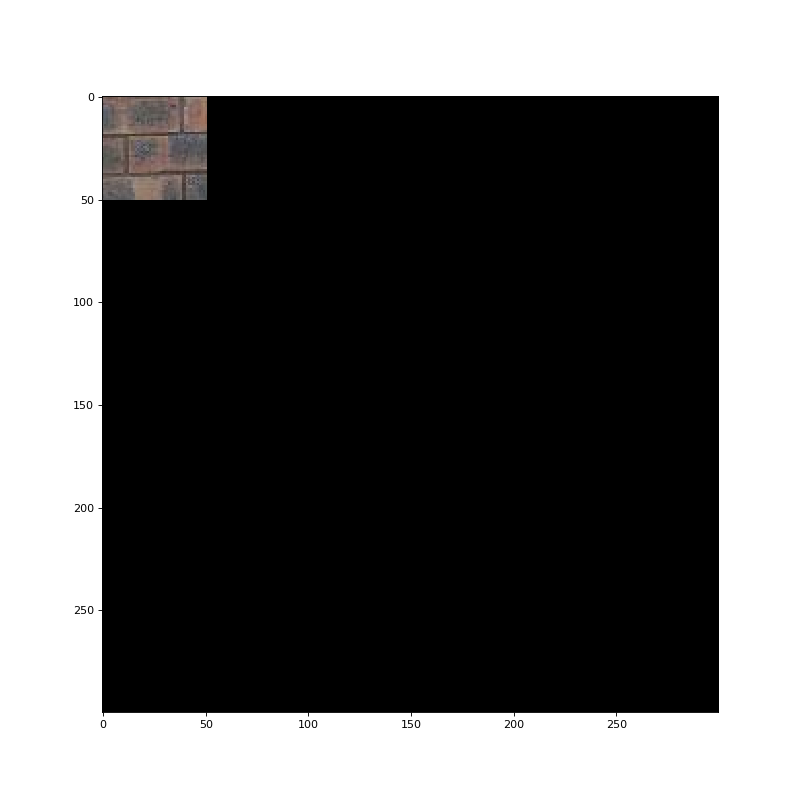

In [118]:
size = 51
sample_image_1 = sample_image(size,sample_img)
size_image = 300
output = np.zeros(shape=(size_image,size_image,3))
output[:size,:size] = sample_image_1
output = output.astype('uint8')
fig, axes = plt.subplots(1, 1)
fig.set_size_inches(10, 10)
axes.imshow(output)


<IPython.core.display.Javascript object>


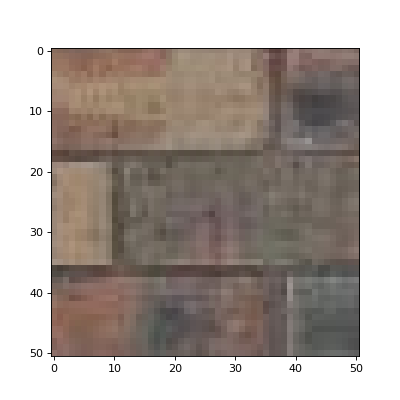

(51, 51, 3)

In [119]:
ssd = ssd_patch_left(10,sample_image_1,51)
sample = choose_sample(15,ssd,10,51,sample_img) 
fig, axes = plt.subplots(1, 1)
fig.set_size_inches(5, 5)
axes.imshow(sample)
sample.shape

In [120]:
#sum of squasres dif
A = sample_image_1[:,51-10:51,:]
B = sample[:,:10,:]
s = (A[:,:,:]-B[:,:,:])**2
s = s[:,:,0]
s =  s.transpose()
s.shape

(10, 51)

In [121]:
#get cut
mask = cut(s)
mask = mask.transpose()



In [122]:
mask = list(mask)

In [123]:

output_in = np.zeros(shape=(51,10,3))
row = 0
col = 0
for x in mask:
    col = 0
    for y in x:
        if y == 0:
            output_in[row,col,:] = A[row,col,:]
        else:
            output_in[row,col,:] = B[row,col,:]
        #print(row,col)
        col += 1
    row += 1
    
            
            
  
    

<IPython.core.display.Javascript object>


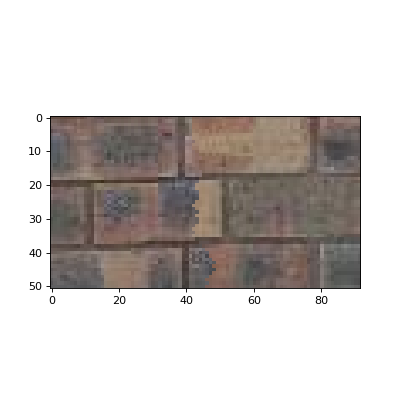

In [124]:
test = output[0:51,51-10:51,:]
test.shape
output[0:51,51-10:51,:] = output_in
output[0:51,51:92,:]=sample[:,10:51,:]

output = output.astype('uint8')
new = output[0:51,0:92,:]
fig, axes = plt.subplots(1, 1)
fig.set_size_inches(5, 5)
axes.imshow(new)

In [26]:
# optional or use cut(err_patch) directly
def customized_cut(bndcost):
    pass

In [9]:
def quilt_cut(sample, out_size, patch_size, overlap, tol):
    """
    Samples square patches of size patchsize from sample using seam finding in order to create an output image of size outsize.
    Feel free to add function parameters
    :param sample: numpy.ndarray
    :param out_size: int
    :param patch_size: int
    :param overlap: int
    :param tol: float
    :return: numpy.ndarray
    """
    
                

In [10]:
res = quilt_cut(sample_img, None, None, None, None)
if res:
    plt.imshow(res)

### part IV: Texture Transfer (30 pts)

In [11]:
def texture_transfer(sample, target):
    """
    Feel free to add function parameters
    """
    pass

### Bells & Whistles

(10 pts) Create and use your own version of cut.m. To get these points, you should create your own implementation without basing it directly on the provided function (you're on the honor code for this one). 

You can simply copy your customized_cut(bndcost) into the box below so that it is easier for us to grade

(15 pts) Implement the iterative texture transfer method described in the paper. Compare to the non-iterative method for two examples.

(up to 20 pts) Use a combination of texture transfer and blending to create a face-in-toast image like the one on top. To get full points, you must use some type of blending, such as feathering or Laplacian pyramid blending.

(up to 40 pts) Extend your method to fill holes of arbitrary shape for image completion. In this case, patches are drawn from other parts of the target image. For the full 40 pts, you should implement a smart priority function (e.g., similar to Criminisi et al.).